# Importaciones

In [1]:
"""
Full demo script exercising all components of the Trading Environment repo.
"""
from trading_lib.imports import *
from trading_lib.trading_environment import (
    DataManager, RiskManager, PerformanceAnalyzer, Optimizer,
    ReportManager, TradingSystem, StrategyManager, StrategyCollection,
    DATA_DIR, MAX_FILE_SIZE
)
from trading_lib.strategies import (
    MovingAverageCrossStrategy, DcaStrategy, DonchianBreakoutStrategy,
    ADXTrendStrategy, ROCStrategy, MACDStrategy, BollingerMeanRevStrategy,
    RSIStrategy, PairTradingStrategy, VWAPStrategy
)

c:\Users\Lesins\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Tests

In [2]:
# 1) Load data
dm = DataManager(DATA_DIR, MAX_FILE_SIZE)
data = dm.load_data(symbols='BTC-USD', period='2y', interval='1d')
print("Data loaded shape:", data.shape)

Data loaded shape: (732, 6)


In [3]:
# 2) RiskManager Demo
price = data['close'].iloc[-1]
rm_pct = RiskManager(method='pct', risk_pct=0.02)
print("Pct size:", rm_pct.calculate_size(10000, price, data))
rm_atr = RiskManager(method='atr', risk_pct=0.01, atr_window=14)
print("ATR size:", rm_atr.calculate_size(10000, price, data, stop_loss=price*0.95))

Pct size: 0.0018765713077671506
ATR size: 0.018765713077671487


In [4]:
# 3) Strategy Demo
strat = MovingAverageCrossStrategy({'short_window':10, 'long_window':20})
sig = strat.generate_signals(data)
print("Signal counts:", sig.value_counts().to_dict())
eq = strat.backtest(data, initial_capital=10000, transaction_cost=0.001)
pa = PerformanceAnalyzer(eq, strat.returns)
print("MA Crossover Performance:\n", pa.summary())

Signal counts: {0: 696, 1: 18, -1: 18}
MA Crossover Performance:
 Total Return    -0.006043
Ann. Return     -0.002084
Ann. Vol         0.068671
Sharpe           0.003787
Max Drawdown    -0.081468
Win Rate         0.017760
Profit Factor    1.002707
Expectancy      -0.004426
dtype: float64


In [5]:
# 4) Optimizer Demo (Grid, Bayes, DE)
print("\n=== Optimizer Demo ===")
subset = [MovingAverageCrossStrategy, MACDStrategy]
# Grid Search
print("-- Grid Search --")
perf_df, equity_map, strategy_obj_map = Optimizer.find_best_strategy(
    subset, data, method='grid', metric='Sharpe'
)
best_sharp_strat_name = perf_df.sort_values(by='Sharpe', ascending=False).index[0]
best_sharp_strat_a = strategy_obj_map[best_sharp_strat_name]
print(f"Grid best: {best_sharp_strat_name} {best_sharp_strat_a}")

# Bayesian Search
print("-- Bayesian Search --")
perf_df, equity_map, strategy_obj_map = Optimizer.find_best_strategy(
    subset, data, method='bayes', metric='Sharpe', n_trials=10, seed=123
)
best_sharp_strat_name = perf_df.sort_values(by='Sharpe', ascending=False).index[0]
best_sharp_strat_b = strategy_obj_map[best_sharp_strat_name]
print(f"Bayes best: {best_sharp_strat_name} {best_sharp_strat_b}")

# Differential Evolution
print("-- DE Search --")
perf_df, equity_map, strategy_obj_map = Optimizer.find_best_strategy(
    subset, data, method='de', metric='Sharpe', maxiter=5, popsize=5
)
best_sharp_strat_name = perf_df.sort_values(by='Sharpe', ascending=False).index[0]
best_sharp_strat_c = strategy_obj_map[best_sharp_strat_name]
print(f"DE best: {best_sharp_strat_name} {best_sharp_strat_c}")


=== Optimizer Demo ===
-- Grid Search --
Grid best: MACD 5/100/7 <trading_lib.strategies.MACDStrategy object at 0x000001C93C985ED0>
-- Bayesian Search --
Bayes best: MACD 12/25/15 <trading_lib.strategies.MACDStrategy object at 0x000001C93C85F8D0>
-- DE Search --
DE best: MA 50/120 <trading_lib.strategies.MovingAverageCrossStrategy object at 0x000001C92C741390>


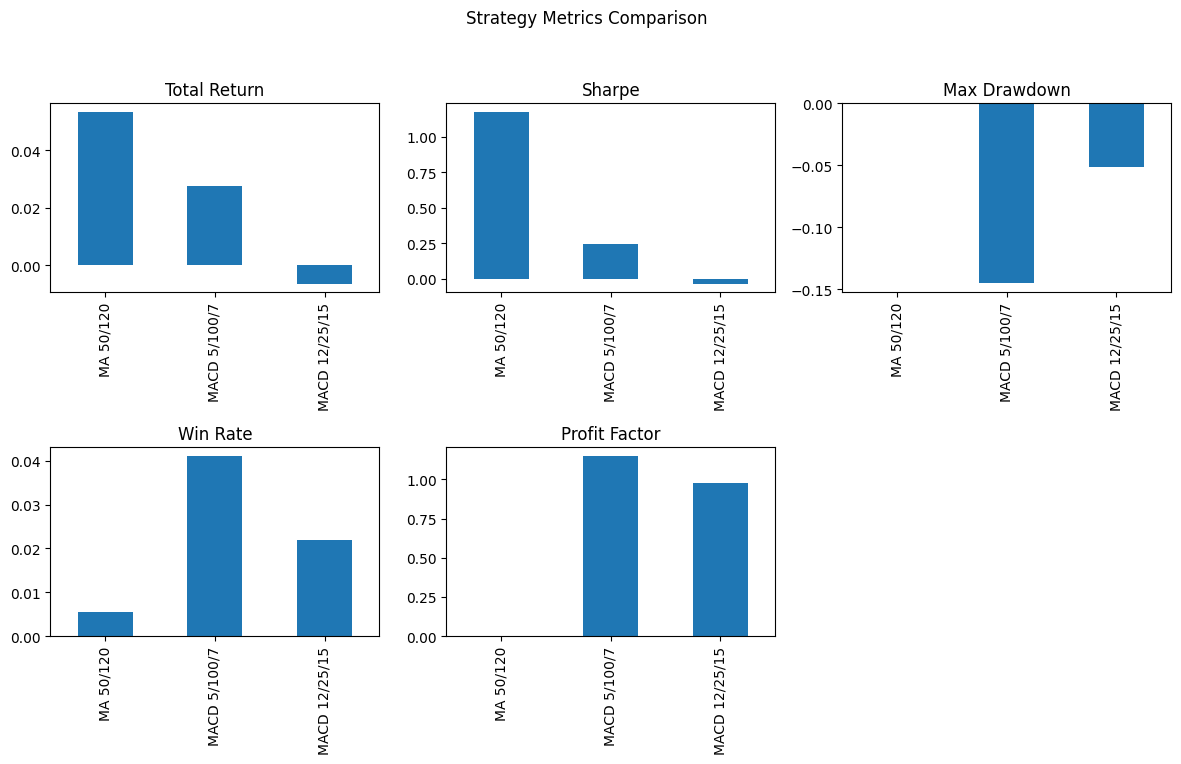

In [ ]:
# 5) ReportManager plotting and metrics
sc = StrategyCollection(strategies=[best_sharp_strat_a, best_sharp_strat_b, best_sharp_strat_c])
perf_df, equity_dict = sc.backtest_and_performance_all(symbol='BTC-USD')
rm = ReportManager()
rm.plot_metrics(perf_df, metrics=['Total Return', 'Sharpe', 'Max Drawdown', 'Win Rate', 'Profit Factor'])

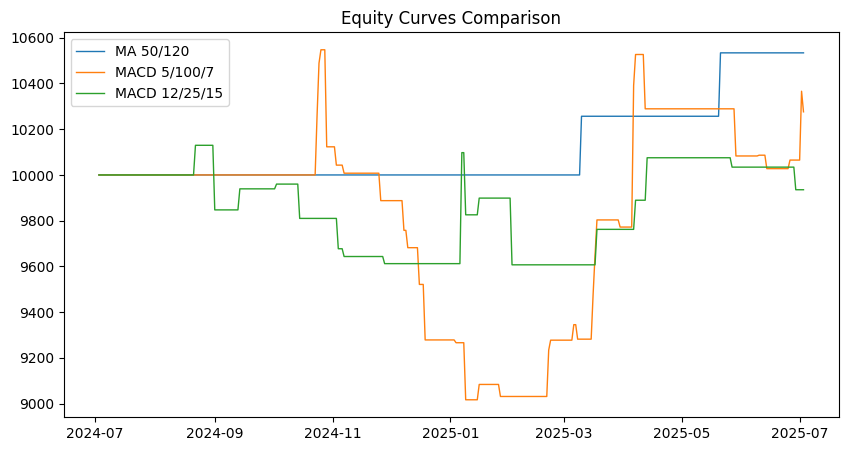

In [16]:
rm.plot_equity_curves(perf_df=perf_df, equity_dict=equity_dict)

In [17]:
perf_df

,Total Return,Ann. Return,Ann. Vol,Sharpe,Max Drawdown,Win Rate,Profit Factor,Expectancy
MA 50/120,0.053398,0.036467,0.030892,1.174693,0.000000,0.005464,NaN,0.000144
MACD 5/100/7,0.027605,0.018926,0.093964,0.245925,-0.145125,0.040984,1.147342,-0.012136
MACD 12/25/15,-0.006470,-0.004459,0.067338,-0.033011,-0.051601,0.021858,0.975826,-0.014159


In [18]:
# 6) TradingSystem Demo
print("\n=== TradingSystem Demo ===")
ts = TradingSystem('BTC-USD', DcaStrategy({'amount':500,'freq':'D'}), risk_manager=RiskManager('fixed', fixed_size=1))
ts.load(period='2y', interval='1d')
eq_ts = ts.run_backtest(save_report=True, initial_capital=10_000, do_print=True, report_name='ts_demo')
print(f"Final TS equity: {eq_ts.iloc[-1]:.2f}")


=== TradingSystem Demo ===
Performance Report (None):
Total Return     2.4966
Ann. Return      0.5387
Ann. Vol         0.4016
Sharpe           1.2728
Max Drawdown    -0.2814
Win Rate         0.5096
Profit Factor    1.2615
Expectancy       0.0020
Final TS equity: 34966.42


In [19]:
# 7) StrategyCollection Demo
grid_params = {'short_window': [5,10], 'long_window': [20,50]}
collection = StrategyCollection(strategy_cls=MovingAverageCrossStrategy, param_grid=grid_params)
eqs = collection.backtest_all('BTC-USD', period='2y', interval='1d')
print("Collection demos backtested strategies:", list(eqs.keys()))

Collection demos backtested strategies: ['MA 5/20', 'MA 5/50', 'MA 10/20', 'MA 10/50']


In [20]:
# 8) StrategyManager Demo
sm = StrategyManager()
strat_sample = MACDStrategy({'fast':12,'slow':26,'signal':9})
sm.save(strat_sample)
loaded = sm.load(strat_sample.name)
print("Loaded sample strategy:", loaded.name)

Loaded sample strategy: MACD 12/26/9


# END